# Dijagnosticka klasifikacija raka dojke

Ucitavanje potrebnih biblioteka

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


**1. Pocetno preprocesiranje podataka**

*Ucitavanje dataset-a*

In [2]:
# lista imena kolona
column_names = [
    "id",
    "diagnosis",    # ciljna promenljiva (B -> 0 ili M -> 1)
    "mean radius", 
    "mean texture", 
    "mean perimeter", 
    "mean area",
    "mean smoothness", 
    "mean compactness", 
    "mean concavity", 
    "mean concave points",
    "mean symmetry", 
    "mean fractal dimension",
    "radius se", 
    "texture se", 
    "perimeter se", 
    "area se",
    "smoothness se", 
    "compactness se", 
    "concavity se", 
    "concave points se",
    "symmetry se", 
    "fractal dimension se",
    "worst radius", 
    "worst texture", 
    "worst perimeter", 
    "worst area",
    "worst smoothness", 
    "worst compactness", 
    "worst concavity", 
    "worst concave points",
    "worst symmetry", 
    "worst fractal dimension"
]

# učitavanje sa imenima kolona
df = pd.read_csv("data.csv", names=column_names)

*Ciscenje i pocetna analiza*

In [3]:
# mapiranje B -> 0, M -> 1
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1}) 

# Provera nedostajucih vrednosti
print("\nNedostajuce vrednosti po kolonama:\n", df.isnull().sum())

# Uklanjanje atributa koji ocigledno ne uticu na izlaz
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print("\nPrvih 5 redova:\n", df.head())
print("\nBroj uzoraka po klasama:\n", df["diagnosis"].value_counts())
df.info()


Nedostajuce vrednosti po kolonama:
 id                         0
diagnosis                  0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius se                  0
texture se                 0
perimeter se               0
area se                    0
smoothness se              0
compactness se             0
concavity se               0
concave points se          0
symmetry se                0
fractal dimension se       0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

Prvih 5 redova:
    d

**2. Eksplorativna analiza skupa**

*Analiza i prikaz korelacije*

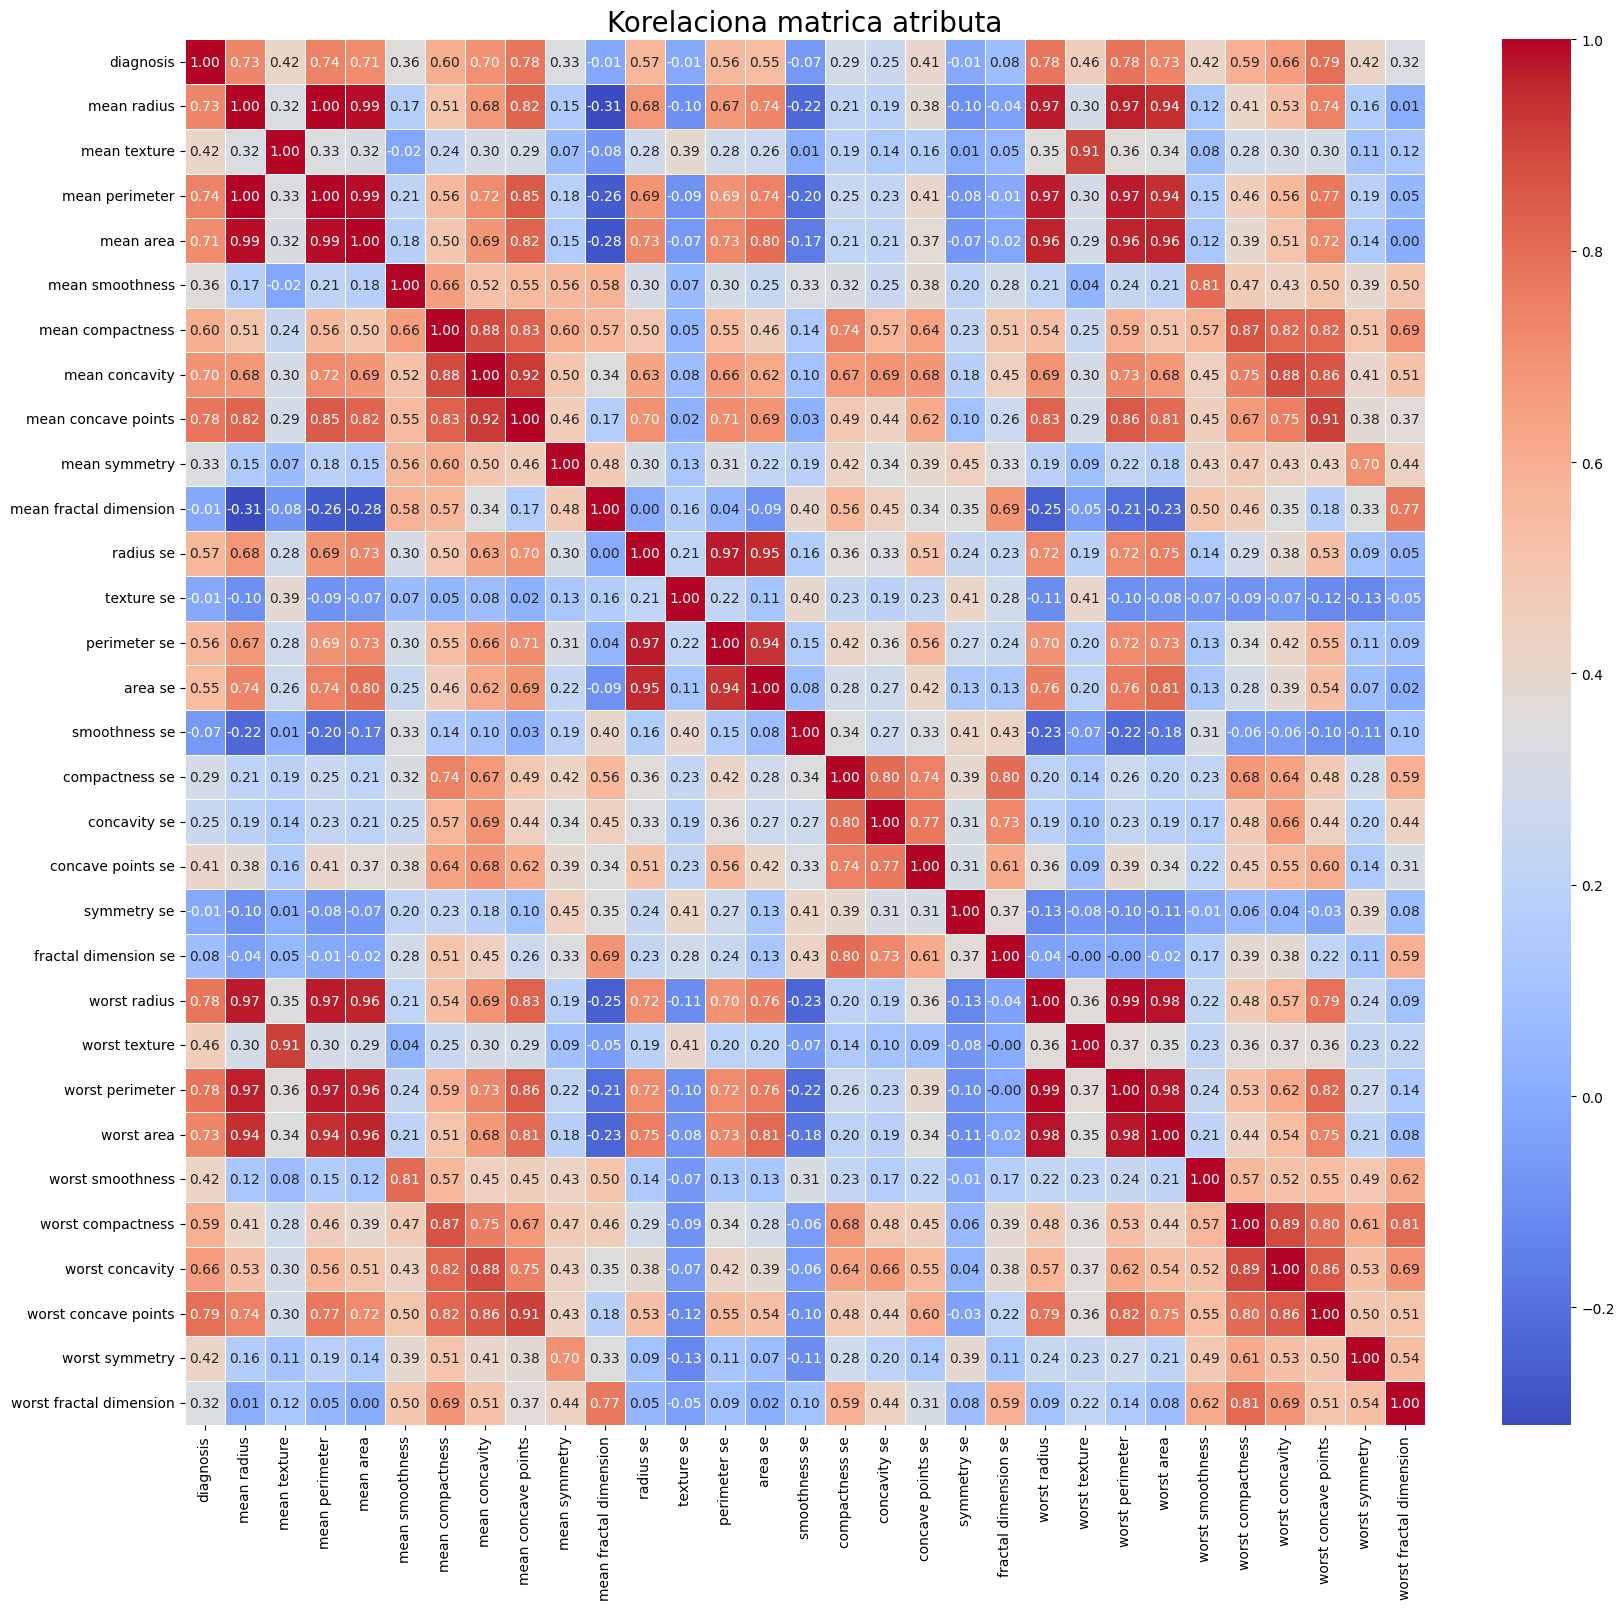

In [4]:
correlation_matrix = df.corr()

# Vizualizacija korelacione matrice
plt.figure(figsize=(20, 18))
sbn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korelaciona matrica atributa', fontsize=20)
plt.show()

# # Prikaz korelacija sa ciljnom promenljivom 'diagnosis'
# print("\nKorelacija sa ciljnom promenljivom 'diagnosis':")
# print(correlation_matrix['diagnosis'].sort_values(ascending=False))

# # Kreiranje box plotova za sve atribute
# plt.figure(figsize=(20, 15))
# for i, column in enumerate(df.drop(columns=['diagnosis']).columns):
#     plt.subplot(5, 6, i + 1)
#     sbn.boxplot(x=df[column])
#     plt.title(column, fontsize=10)
#     plt.tight_layout()
# plt.suptitle('Box Plotovi za sve atribute', fontsize=20, y=1.02)
# plt.show()

# # Prikaz statističkog pregleda
# print("\nStatistički pregled atributa:")
# print(df.describe())

**3. Odabir i treniranje modela**

*Odabir atributa i setova*

In [5]:
# Odvajanje atributa (X) i ciljne promenljive (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Podela podataka na trening (80%) i test (20%) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Oblik trening skupa: {X_train.shape}")
print(f"Oblik test skupa: {X_test.shape}")

# Skaliranje atributa (obavezno za LR, SVM, KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Oblik trening skupa: (455, 30)
Oblik test skupa: (114, 30)


**Trening modela**

Logisticka regresija

In [6]:
# Inicijalizacija recnika za cuvanje predikcija i metrika
predictions = {}
performance_metrics = {}
models = {}

# Logisticka regresija
print("--- Treniranje modela: Logisticka Regresija ---")
model_lr = LogisticRegression(solver='liblinear', random_state=42)
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
predictions['Logisticka Regresija'] = y_pred_lr
models['Logisticka Regresija'] = model_lr
print("Model Logisticke Regresije je obucen.")


--- Treniranje modela: Logisticka Regresija ---
Model Logisticke Regresije je obucen.


Slucajna suma

In [7]:
print("--- Treniranje modela: Slucajna suma ---")
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
predictions['Slucajna suma'] = y_pred_rf
models['Slucajna suma'] = model_rf
print("Model Slucajne sume je obucen.")


--- Treniranje modela: Slucajna suma ---
Model Slucajne sume je obucen.


KNN

In [8]:
print("--- Treniranje modela: KNN ---")
model_knn = KNeighborsClassifier()
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)
predictions['KNN'] = y_pred_knn
models['KNN'] = model_knn
print("KNN model je obucen.")

--- Treniranje modela: KNN ---
KNN model je obucen.


SVM

In [9]:
print("--- Treniranje modela: SVM ---")
model_svm = SVC(random_state=42)
model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)
predictions['SVM'] = y_pred_svm
models['SVM'] = model_svm
print("SVM model je obucen.")

--- Treniranje modela: SVM ---
SVM model je obucen.


***Uporedjivanje preformanis***


 Rezultati i poredjenje modela:


--- Model: Logisticka Regresija ---


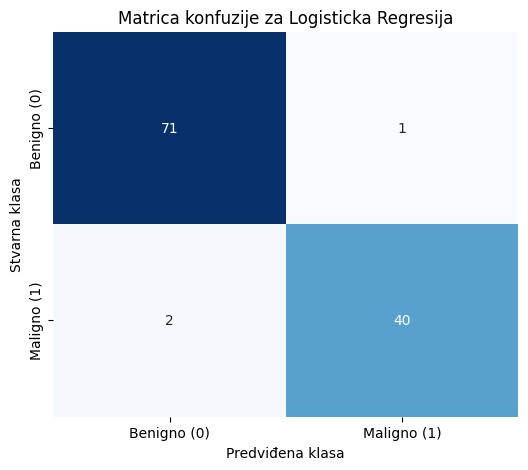

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


--- Model: Slucajna suma ---


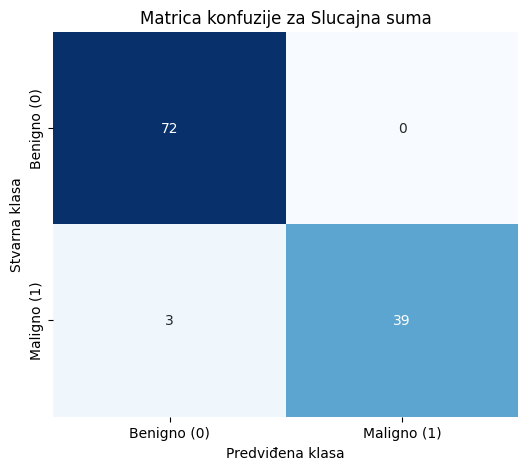

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


--- Model: KNN ---


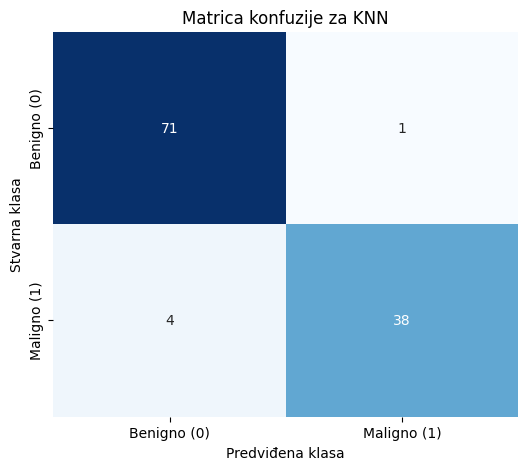

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


--- Model: SVM ---


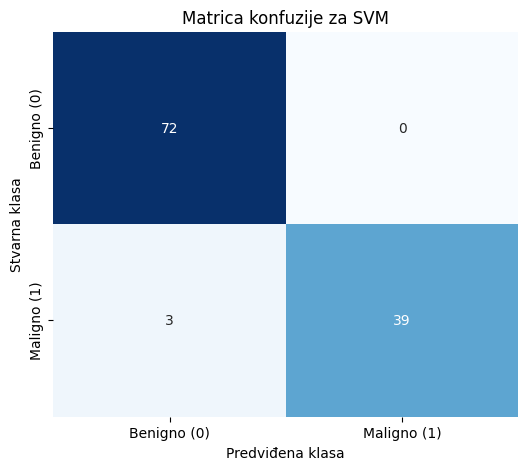

Izvestaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [10]:
print("\n Rezultati i poredjenje modela:\n")

for model_name, y_pred in predictions.items():
    print(f"\n--- Model: {model_name} ---")
    
    # Računanje metrika i čuvanje za tabelu
    performance_metrics[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    # Matrica konfuzije
    cm = confusion_matrix(y_test, y_pred)
    
    # Prikaz matrice konfuzije
    plt.figure(figsize=(6, 5))
    sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benigno (0)', 'Maligno (1)'],
                yticklabels=['Benigno (0)', 'Maligno (1)'])
    plt.xlabel('Predviđena klasa')
    plt.ylabel('Stvarna klasa')
    plt.title(f'Matrica konfuzije za {model_name}')
    plt.show()
    
    # Prikaz izveštaja o klasifikaciji
    print("Izvestaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))

***Analiza i tumacenje rezultata***

--- Tabela performansi svih modela ---
                      Accuracy  Precision  Recall  F1-Score
Logisticka Regresija    0.9737     0.9756  0.9524    0.9639
Slucajna suma           0.9737     1.0000  0.9286    0.9630
KNN                     0.9561     0.9744  0.9048    0.9383
SVM                     0.9737     1.0000  0.9286    0.9630


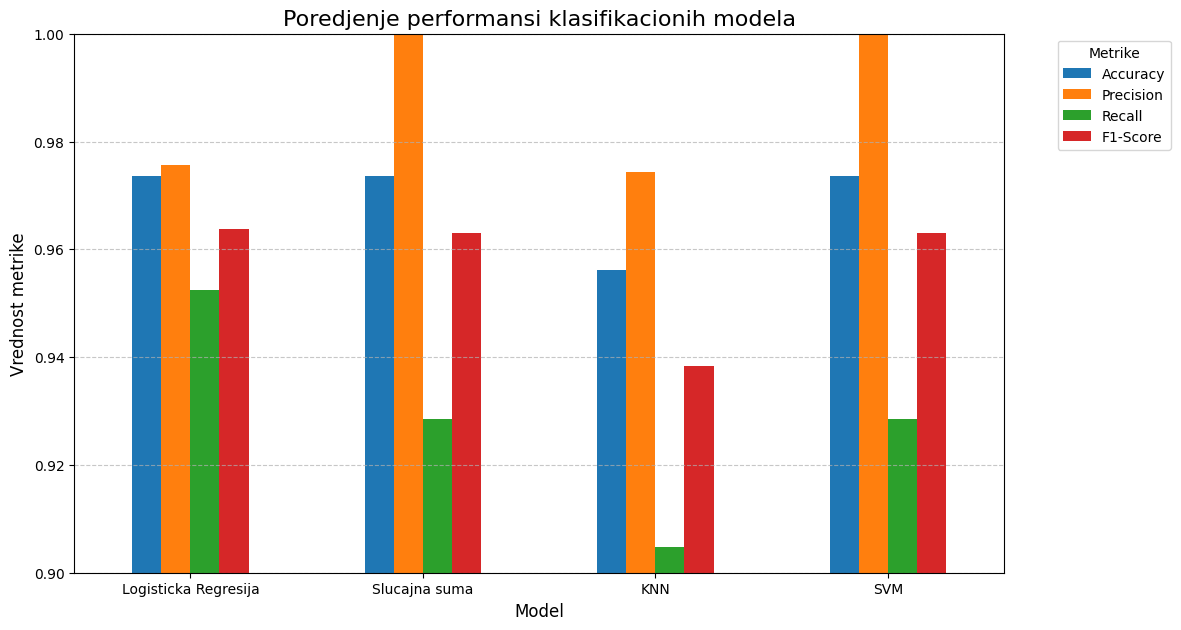


--- 10 najvaznijih atributa prema modelu Slucajna suma ---
             Atribut  Vaznost
          worst area   0.1514
worst concave points   0.1265
        worst radius   0.0935
     worst perimeter   0.0836
 mean concave points   0.0811
      mean perimeter   0.0771
         mean radius   0.0620
      mean concavity   0.0508
           mean area   0.0459
     worst concavity   0.0300


C:\Users\Srdjan\AppData\Local\Temp\ipykernel_13044\4023427452.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances.head(10), palette='viridis')


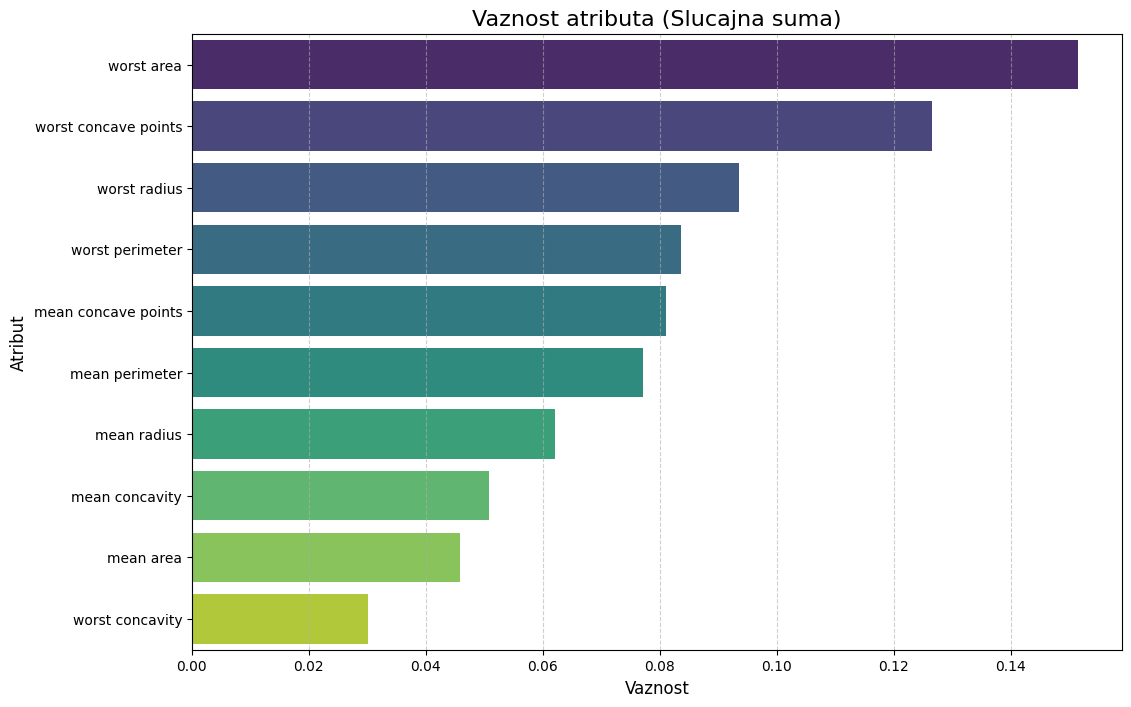


--- Tumacenje rezultata i preporuke ---
Svi modeli su pokazali izuzetno visoke performanse, sto ukazuje na to da su podaci visokog kvaliteta.
Modeli **Slučajne sume** i **SVM** su postigli gotovo savršene rezultate na test podacima, sa visokim preciznim odzivom za malignu klasu.
Najvažniji atributi, kao što su 'worst concave points(najveci broj konkavnih tacaka)' i 'worst perimeter(najveca vrednost obima)', kljucni su za razlikovanje benignih i malignih tumora.


In [11]:
# Prikaz tabela performansi
metrics_df = pd.DataFrame(performance_metrics).T
print("--- Tabela performansi svih modela ---")
print(metrics_df.to_string(float_format="%.4f"))

# Vizualizacija metrika
metrics_df.plot(kind='bar', figsize=(12, 7), rot=0)
plt.title('Poredjenje performansi klasifikacionih modela', fontsize=16)
plt.ylabel('Vrednost metrike', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0.9, 1.0)
plt.legend(title='Metrike', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Analiza vaznosti atributa (samo za Random Forest)
rf_model = models['Slucajna suma']
feature_importances = pd.DataFrame({
    'Atribut': X.columns,
    'Vaznost': rf_model.feature_importances_
}).sort_values(by='Vaznost', ascending=False)

print("\n--- 10 najvaznijih atributa prema modelu Slucajna suma ---")
print(feature_importances.head(10).to_string(index=False, float_format="%.4f"))

# Vizualizacija najvaznijih atributa
plt.figure(figsize=(12, 8))
sbn.barplot(x='Vaznost', y='Atribut', data=feature_importances.head(10), palette='viridis')
plt.title('Vaznost atributa (Slucajna suma)', fontsize=16)
plt.xlabel('Vaznost', fontsize=12)
plt.ylabel('Atribut', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Tumačenje rezultata
print("\n--- Tumacenje rezultata i preporuke ---")
print("Svi modeli su pokazali izuzetno visoke performanse, sto ukazuje na to da su podaci visokog kvaliteta.")
print("Modeli **Slučajne sume** i **SVM** su postigli gotovo savršene rezultate na test podacima, sa visokim preciznim odzivom za malignu klasu.")
print("Najvažniji atributi, kao što su 'worst concave points(najveci broj konkavnih tacaka)' i 'worst perimeter(najveca vrednost obima)', kljucni su za razlikovanje benignih i malignih tumora.")